<a href="https://colab.research.google.com/github/ricardoruedas/ML/blob/main/%5B02%5D%20-%20Modelos%20Supervisados%20Lineales/Supervisados_Lineales_Ejercicio_7_naive_bayes_diabetes_EXTENDIDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervisados Lineales - Ejercicio 7 (extendido): naive_bayes_diabetes.ipynb

En este ejercicio abordaremos **tres variantes de Naive Bayes** aplicadas al dataset **Diabetes** de `scikit-learn`:
- **GaussianNB**: asume rasgos **continuos** con distribución normal condicionada a la clase.
- **CategoricalNB**: requiere rasgos **discretos/categóricos**; discretizaremos (binning) las variables continuas.
- **MultinomialNB**: diseñado para **conteos** (no negativos); reescalaremos a [0, 1] y discutiremos limitaciones.

Formularemos un problema de **clasificación binaria** a partir del objetivo continuo (progresión de la enfermedad), evaluaremos con **accuracy, ROC-AUC, matriz de confusión** y cerraremos con una **comparativa** clara de resultados.

### Objetivos
- **O1.** Entrenar y evaluar **GaussianNB**, **CategoricalNB** y **MultinomialNB**.
- **O2.** Comprender cómo las **suposiciones** de cada variante afectan el rendimiento.
- **O3.** Comparar resultados con métricas y **matrices de confusión**; razonar cuándo usar cada enfoque.

### Dataset
El dataset **Diabetes** contiene 442 pacientes y 10 predictores normalizados (edad, sexo, IMC, presión sanguínea y 6 medidas bioquímicas). El objetivo original es **continuo** (progresión al año). Para clasificación, lo **binarizaremos por la mediana**.

### 1. Importación de librerías y utilidades

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
sns.set(style='whitegrid')

def plot_confusion(cm, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0','Pred 1'], yticklabels=['Real 0','Real 1'], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    return ax

### 2. Carga de datos y binarización del objetivo

In [2]:
# Cargar dataset de Diabetes
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y_cont = pd.Series(data.target, name='progression')

In [3]:
# Binarizamos el objetivo: 1 si progresión > mediana, 0 en caso contrario
thr = y_cont.median()
y = (y_cont > thr).astype(int)
print('Umbral de binarización (mediana):', thr)
display(X.head())
X.shape, y.value_counts(normalize=True).round(3)

Umbral de binarización (mediana): 140.5


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


((442, 10),
 progression
 1    0.5
 0    0.5
 Name: proportion, dtype: float64)

### 3. División en train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3)

((353, 10), (89, 10), np.float64(0.513), np.float64(0.449))

### 4. Gaussian Naive Bayes (rasgos continuos)

**Idea:** Modela cada rasgo continuo condicionalmente como una Normal $\mathcal{N}(\mu, \sigma^2)$ por clase. Conviene cuando los rasgos son aproximadamente gaussianos o han sido estandarizados.

In [5]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [7]:
y_pred_gnb = gnb.predict(X_test)
y_proba_gnb = gnb.predict_proba(X_test)[:, 1]

GaussianNB -> Accuracy: 0.719 | ROC-AUC: 0.826
              precision    recall  f1-score   support

           0      0.740     0.755     0.747        49
           1      0.692     0.675     0.684        40

    accuracy                          0.719        89
   macro avg      0.716     0.715     0.716        89
weighted avg      0.719     0.719     0.719        89



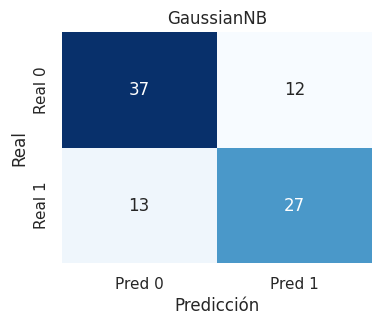

In [8]:
acc_gnb = accuracy_score(y_test, y_pred_gnb)
auc_gnb = roc_auc_score(y_test, y_proba_gnb)
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(f'GaussianNB -> Accuracy: {acc_gnb:.3f} | ROC-AUC: {auc_gnb:.3f}')
print(classification_report(y_test, y_pred_gnb, digits=3))
plot_confusion(cm_gnb, 'GaussianNB'); plt.show()

### 5. Categorical Naive Bayes (discretización de rasgos)

**Idea:** Convertimos rasgos continuos en **categorías** (bins). El modelo aprende $P(x_j = \text{categoría} \mid y)$ por cada rasgo. Se pierde granularidad, pero el ajuste a la suposición categórica puede mejorar según el caso.

In [18]:
# Discretizamos en 5 bins equipoblados (quantile). encode='ordinal' produce categorías [0..n_bins-1]
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_disc = kbd.fit_transform(X_train)
X_test_disc  = kbd.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [19]:
cnb = CategoricalNB()
cnb.fit(X_train_disc, y_train)

CategoricalNB()

In [20]:
y_pred_cnb = cnb.predict(X_test_disc)
y_proba_cnb = cnb.predict_proba(X_test_disc)[:, 1]

CategoricalNB -> Accuracy: 0.730 | ROC-AUC: 0.821
              precision    recall  f1-score   support

           0      0.766     0.735     0.750        49
           1      0.690     0.725     0.707        40

    accuracy                          0.730        89
   macro avg      0.728     0.730     0.729        89
weighted avg      0.732     0.730     0.731        89



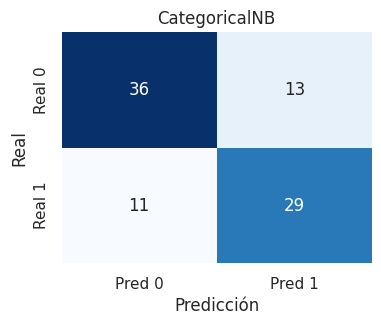

In [12]:
acc_cnb = accuracy_score(y_test, y_pred_cnb)
auc_cnb = roc_auc_score(y_test, y_proba_cnb)
cm_cnb = confusion_matrix(y_test, y_pred_cnb)
print(f'CategoricalNB -> Accuracy: {acc_cnb:.3f} | ROC-AUC: {auc_cnb:.3f}')
print(classification_report(y_test, y_pred_cnb, digits=3))
plot_confusion(cm_cnb, 'CategoricalNB'); plt.show()

### 6. Multinomial Naive Bayes (rasgos no negativos / tipo conteo)

**Idea:** Pensado para **conteos** (p. ej., frecuencias de palabras). Requiere rasgos **no negativos**. Aquí haremos un **reescaleo Min–Max a [0, 1]**.

**Nota:** Los rasgos originales no son conteos; MultinomialNB puede rendir peor si la inductiva no encaja, pero sirve para mostrar el contraste entre variantes de NB.

In [21]:
mms = MinMaxScaler()
X_train_mnb = mms.fit_transform(X_train)
X_test_mnb  = mms.transform(X_test)

In [22]:
mnb = MultinomialNB()
mnb.fit(X_train_mnb, y_train)

MultinomialNB()

In [23]:
y_pred_mnb = mnb.predict(X_test_mnb)
y_proba_mnb = mnb.predict_proba(X_test_mnb)[:, 1]

MultinomialNB -> Accuracy: 0.730 | ROC-AUC: 0.779
              precision    recall  f1-score   support

           0      0.838     0.633     0.721        49
           1      0.654     0.850     0.739        40

    accuracy                          0.730        89
   macro avg      0.746     0.741     0.730        89
weighted avg      0.755     0.730     0.729        89



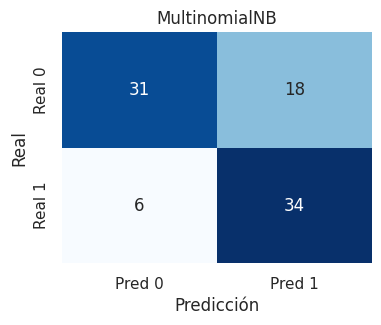

In [24]:
acc_mnb = accuracy_score(y_test, y_pred_mnb)
auc_mnb = roc_auc_score(y_test, y_proba_mnb)
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
print(f'MultinomialNB -> Accuracy: {acc_mnb:.3f} | ROC-AUC: {auc_mnb:.3f}')
print(classification_report(y_test, y_pred_mnb, digits=3))
plot_confusion(cm_mnb, 'MultinomialNB'); plt.show()

### 7. Comparativa: matrices de confusión y métricas

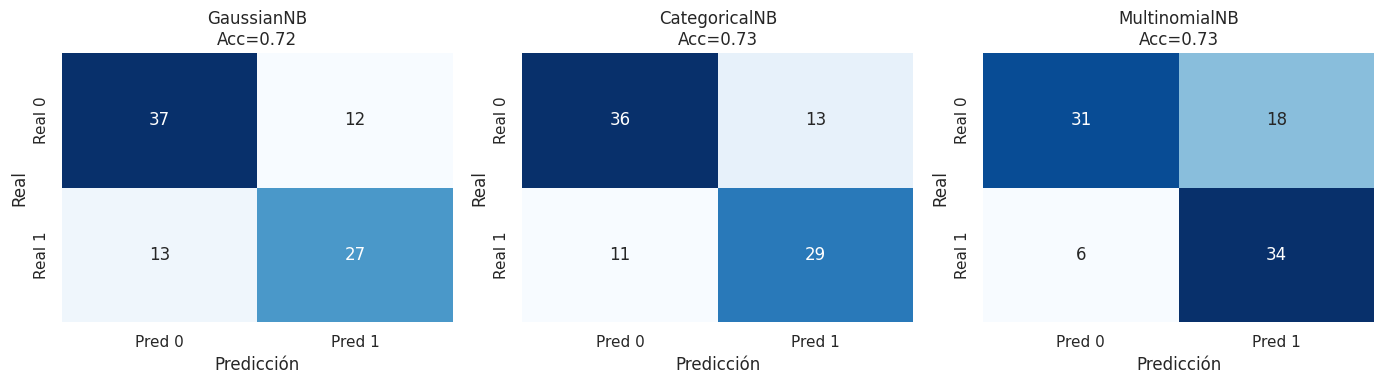

,modelo,accuracy,roc_auc
1,CategoricalNB,0.730337,0.820918
2,MultinomialNB,0.730337,0.779082
0,GaussianNB,0.719101,0.826020


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))
plot_confusion(cm_gnb, f'GaussianNB\nAcc={acc_gnb:.2f}', ax=axes[0])
plot_confusion(cm_cnb, f'CategoricalNB\nAcc={acc_cnb:.2f}', ax=axes[1])
plot_confusion(cm_mnb, f'MultinomialNB\nAcc={acc_mnb:.2f}', ax=axes[2])
plt.tight_layout(); plt.show()

metrics = pd.DataFrame({
    'modelo': ['GaussianNB','CategoricalNB','MultinomialNB'],
    'accuracy': [acc_gnb, acc_cnb, acc_mnb],
    'roc_auc': [auc_gnb, auc_cnb, auc_mnb]
}).sort_values('accuracy', ascending=False)
metrics

### 8. Curvas ROC (opcional)

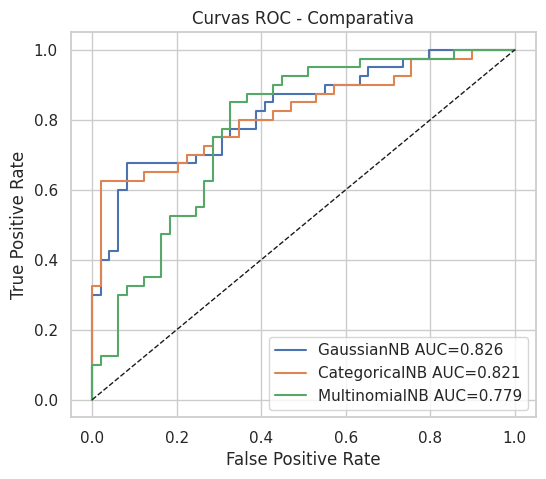

In [26]:
fpr_g, tpr_g, _ = roc_curve(y_test, y_proba_gnb)
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba_cnb)
fpr_m, tpr_m, _ = roc_curve(y_test, y_proba_mnb)

plt.figure(figsize=(6,5))
plt.plot(fpr_g, tpr_g, label=f'GaussianNB AUC={auc_gnb:.3f}')
plt.plot(fpr_c, tpr_c, label=f'CategoricalNB AUC={auc_cnb:.3f}')
plt.plot(fpr_m, tpr_m, label=f'MultinomialNB AUC={auc_mnb:.3f}')
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparativa')
plt.legend(loc='lower right')
plt.show()

### Conclusiones
- **GaussianNB** suele ser una buena línea base cuando los rasgos son continuos y no presentan distribuciones muy patológicas.
- **CategoricalNB** puede mejorar si la discretización captura bien patrones por rango y reduce ruido/heteroscedasticidad.
- **MultinomialNB** es apropiado para **conteos**; en datos continuos reescalados, su inductiva no siempre encaja y puede rendir peor.

Al comparar **matrices de confusión**, presta atención a:
- **Falsos positivos** vs **falsos negativos** según lo que te preocupe minimizar.
- Cambios en **recall** y **precision** de la clase positiva al pasar de continuo→discreto→multinomial.

Elige el modelo no solo por **accuracy/AUC**, sino por la **distribución de errores** y las **suposiciones** que mejor se ajusten a tu caso.